<a href="https://colab.research.google.com/github/GuangyuNie/MAE_598_Optimization/blob/master/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from __future__ import division
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt
import torch

In [2]:
class ComplianceLoss():
    def __init__(self, nelx, nely, alpha,E_min=1e-9, E_max = 1, nu = 0.3, dim=2):
        self.nelx = nelx
        self.nely = nely
        self.alpha = alpha
        self.E_min = E_min
        self.E_max = E_max

        self.gamma = 3.0
        # if dim == 2:
        #     self.gamma = max(2/(1-nu), 4/(1+nu))
        # elif dim == 3:
        #     self.gamma = max(15 * (1-nu)/(7-5*nu), 1.5*(1-nu)/(1-2*nu))
        # else:
        #     raise AttributeError('Dimension needs to be 2 or 3')

        self.ndof = 2 * (nelx + 1) * (nely + 1) # 2 degree of freedom for each node, (x+1)(y+1) number of node
        x = alpha * np.ones(nely * nelx, dtype=float)
        xold = x.copy()
        xPhys = x.copy()
        self.edofMat = np.zeros((nelx * nely, 8), dtype=int)
        for elx in range(nelx):
            for ely in range(nely):
                el = ely + elx * nely
                n1 = (nely + 1) * elx + ely
                n2 = (nely + 1) * (elx + 1) + ely
                # get num of dof on each node, spring node system
                self.edofMat[el, :] = np.array(
                    [2 * n1 + 2, 2 * n1 + 3, 2 * n2 + 2, 2 * n2 + 3, 2 * n2, 2 * n2 + 1, 2 * n1, 2 * n1 + 1])
        # Construct the index pointers for the coo format
        self.iK = np.kron(self.edofMat, np.ones((8, 1))).flatten()
        self.jK = np.kron(self.edofMat, np.ones((1, 8))).flatten()



        dofs = np.arange(2 * (nelx + 1) * (nely + 1))
        fixed = np.union1d(dofs[0:2 * (nely + 1):2], np.array([2 * (nelx + 1) * (nely + 1) - 1]))
        self.free = np.setdiff1d(dofs, fixed)

    def get_actual_f(self, floc,fval=-1):
        f = np.zeros((self.ndof, 1))
        f[floc, 0] = fval
        idx = torch.tensor(self.free)
        f = torch.tensor(f,dtype=torch.float32)#.to_sparse().index_select(0,idx)
        return f

    # element stiffness matrix
    def lk(self):
        E = 1
        nu = 0.3
        k = np.array(
            [1 / 2 - nu / 6, 1 / 8 + nu / 8, -1 / 4 - nu / 12, -1 / 8 + 3 * nu / 8, -1 / 4 + nu / 12, -1 / 8 - nu / 8,
            nu / 6, 1 / 8 - 3 * nu / 8])
        KE = E / (1 - nu ** 2) * np.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                                          [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                                          [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                                          [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                                          [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                                          [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                                          [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                                          [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])
        return (KE)


    # Optimality criterion
    def oc(self, x, dc, dv):
        l1 = 0
        l2 = 1e9
        move = 0.2
        # reshape to perform vector operations
        xnew = np.zeros(self.nelx * self.nely)
        while (l2 - l1) / (l1 + l2) > 1e-3:
            lmid = 0.5 * (l2 + l1)
            xnew[:] = np.maximum(0.0,
                                np.maximum(x - move, np.minimum(1.0, np.minimum(x + move, x * np.sqrt(-dc / dv / lmid)))))
            gt = np.sum((dv * (xnew - x)))
            if gt > 0:
                l1 = lmid
            else:
                l2 = lmid
        return (xnew, gt)



ndes: 120 x 40 volfrac: 0.4
it.: 1 , obj.: 1461.393 Vol.: 0.400, ch.: 0.200
it.: 2 , obj.: 784.139 Vol.: 0.400, ch.: 0.200
it.: 3 , obj.: 476.302 Vol.: 0.400, ch.: 0.200
it.: 4 , obj.: 325.665 Vol.: 0.400, ch.: 0.200
it.: 5 , obj.: 266.709 Vol.: 0.400, ch.: 0.200
it.: 6 , obj.: 241.906 Vol.: 0.400, ch.: 0.200
it.: 7 , obj.: 225.129 Vol.: 0.400, ch.: 0.200
it.: 8 , obj.: 214.449 Vol.: 0.400, ch.: 0.200
it.: 9 , obj.: 207.339 Vol.: 0.400, ch.: 0.200
it.: 10 , obj.: 202.166 Vol.: 0.400, ch.: 0.200
it.: 11 , obj.: 197.857 Vol.: 0.400, ch.: 0.200
it.: 12 , obj.: 193.560 Vol.: 0.400, ch.: 0.200
it.: 13 , obj.: 189.550 Vol.: 0.400, ch.: 0.200
it.: 14 , obj.: 186.675 Vol.: 0.400, ch.: 0.200
it.: 15 , obj.: 184.160 Vol.: 0.400, ch.: 0.200
it.: 16 , obj.: 182.039 Vol.: 0.400, ch.: 0.172
it.: 17 , obj.: 180.834 Vol.: 0.400, ch.: 0.162
it.: 18 , obj.: 180.037 Vol.: 0.400, ch.: 0.171
it.: 19 , obj.: 179.363 Vol.: 0.400, ch.: 0.200
it.: 20 , obj.: 178.821 Vol.: 0.400, ch.: 0.189
it.: 21 , obj.: 178.

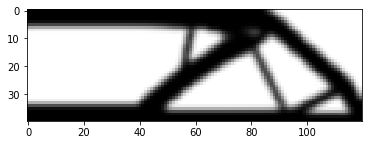

In [29]:


def main(nelx, nely, volfrac, penal, rmin, ft):
    print("ndes: " + str(nelx) + " x " + str(nely),"volfrac: " + str(volfrac))
    loss_utils = ComplianceLoss(nelx, nely, volfrac)
    # Max and min stiffness
    Emin = 1e-9
    Emax = 1.0
    # dofs:
    ndof = 2 * (nelx + 1) * (nely + 1)
    # Allocate design variables (as array), initialize and allocate sens.
    x = volfrac * np.ones(nely * nelx, dtype=float)
    xold = x.copy()
    xPhys = x.copy()
    dc = np.zeros((nely, nelx), dtype=float)
    KE = loss_utils.lk()

    # Filter: Build (and assemble) the index+data vectors for the coo matrix format
    nfilter = int(nelx * nely * ((2 * (np.ceil(rmin) - 1) + 1) ** 2))
    iH = np.zeros(nfilter)
    jH = np.zeros(nfilter)
    sH = np.zeros(nfilter)
    cc = 0
    for i in range(nelx):
        for j in range(nely):
            row = i * nely + j
            kk1 = int(np.maximum(i - (np.ceil(rmin) - 1), 0))
            kk2 = int(np.minimum(i + np.ceil(rmin), nelx))
            ll1 = int(np.maximum(j - (np.ceil(rmin) - 1), 0))
            ll2 = int(np.minimum(j + np.ceil(rmin), nely))
            for k in range(kk1, kk2):
                for l in range(ll1, ll2):
                    col = k * nely + l
                    fac = rmin - np.sqrt(((i - k) * (i - k) + (j - l) * (j - l)))
                    iH[cc] = row
                    jH[cc] = col
                    sH[cc] = np.maximum(0.0, fac)
                    cc = cc + 1

    # Finalize assembly and convert to csc format
    H = coo_matrix((sH, (iH, jH)), shape=(nelx * nely, nelx * nely)).tocsc()
    
    Hs = H.sum(1)
    # BC's and support
    dofs = np.arange(2 * (nelx + 1) * (nely + 1))
    fixed = np.union1d(dofs[0:2 * (nely + 1):2], np.array([2 * (nelx + 1) * (nely + 1) - 1]))
    free = np.setdiff1d(dofs, fixed)
    # Solution and RHS vectors
    f = np.zeros((ndof, 1))
    u = np.zeros((ndof, 1))
    # Set load

    xloc = 39
    yloc = 119
    floc = (2 * yloc + 1) + 2 * xloc * (nely + 1)
    f[floc, 0] = -1
    # Initialize plot and plot the initial design

    plt.ion()  # Ensure that redrawing is possible
    fig, ax = plt.subplots()
    im = ax.imshow(-xPhys.reshape((nelx, nely)).T, cmap='gray',interpolation='none', norm=colors.Normalize(vmin=-1, vmax=0))
    fig.show()

    loop = 0
    change = 1
    dv = np.ones(nely * nelx)
    dc = np.ones(nely * nelx)
    ce = np.ones(nely * nelx)
    while change > 0.05 and loop < 2000:
        loop = loop + 1
        # Setup and solve FE problem
        sK = ((KE.flatten()[np.newaxis]).T * (Emin + (xPhys) ** penal * (Emax - Emin))).flatten(order='F')
        K = coo_matrix((sK, (loss_utils.iK, loss_utils.jK)), shape=(ndof, ndof)).tocsc()
        # Remove constrained dofs from matrix
        K = K[free, :][:, free]
        # Solve system
        u[free, 0] = spsolve(K, f[free, 0])
        # Objective and sensitivity
        ce[:] = (np.dot(u[loss_utils.edofMat].reshape(nelx * nely, 8), KE) * u[loss_utils.edofMat].reshape(nelx * nely, 8)).sum(1)
        obj = ((Emin + xPhys ** penal * (Emax - Emin)) * ce).sum()
        dc[:] = (-penal * xPhys ** (penal - 1) * (Emax - Emin)) * ce
        dv[:] = np.ones(nely * nelx)

        # Sensitivity filtering:
        if ft == 0:
            dc[:] = np.asarray((H * (x * dc))[np.newaxis].T / Hs)[:, 0] / np.maximum(0.001, x)
        elif ft == 1:
            dc[:] = np.asarray(H * (dc[np.newaxis].T / Hs))[:, 0]
            dv[:] = np.asarray(H * (dv[np.newaxis].T / Hs))[:, 0]
        # Optimality criteria
        xold[:] = x
        (x[:], g) = loss_utils.oc(x, dc, dv)
        # Filter design variables

        xPhys[:] = np.asarray(H * x[np.newaxis].T / Hs)[:, 0]

        change = np.linalg.norm(x.reshape(nelx * nely, 1) - xold.reshape(nelx * nely, 1), np.inf)
        im.set_array(-xPhys.reshape((nelx, nely)).T)
        fig.canvas.draw()
        print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format( \
            loop, obj, (volfrac * nelx * nely) / (nelx * nely), change))
    plt.show()

# The real main driver
if __name__ == "__main__":
    # Default input parameters
    nelx = 120
    nely = 40
    volfrac = 0.4
    rmin = 2.5
    penal = 3.0
    ft = 1

    main(nelx, nely, volfrac, penal, rmin, ft)


Location of the force shown as below

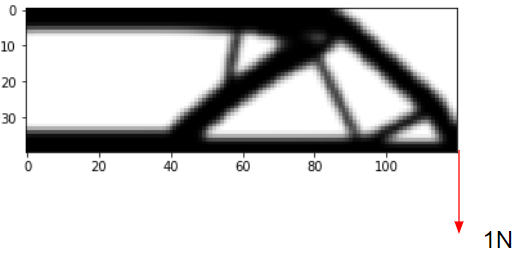